# Ant Simulation Multirun Analysis

This notebook loads and analyzes data from multiple simulation runs with both the `direct` and `stigmergy` pheromone models. It consolidates all runs into a structured DataFrame that includes:

1. Run IDs and pheromone model types
2. Parameter values specific to each run
3. Simulation results from each run

This allows easy filtering and analysis by parameter combinations.

In [1]:
import os
import glob
import yaml
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from pathlib import Path
# from scipy.spatial import distance
# from scipy.cluster.hierarchy import linkage, fcluster
# from scipy.interpolate import interp1d
from sklearn.cluster import DBSCAN
import networkx as nx
from itertools import combinations

## Configuration for Data Loading

Choose which models to load and where to find the multirun data.

In [2]:
# Choose which model data to load
LOAD_DIRECT = True
LOAD_STIGMERGY = True

# Base directory for multirun data
MULTIRUN_BASE = "./multirun"

# Find the most recent run directories for each model
# Change these patterns if you want to load specific runs
def find_latest_run_dir(model_type):
    model_dirs = sorted(glob.glob(f"{MULTIRUN_BASE}/{model_type}/*/"), 
                         key=os.path.getmtime, 
                         reverse=True)
    return model_dirs[0] if model_dirs else None

# Get latest run directories
if LOAD_DIRECT:
    DIRECT_RUN_DIR = find_latest_run_dir("direct")
    print(f"Direct model run directory: {DIRECT_RUN_DIR}")

if LOAD_STIGMERGY:
    STIGMERGY_RUN_DIR = find_latest_run_dir("stigmergy")
    print(f"Stigmergy model run directory: {STIGMERGY_RUN_DIR}")
    
# Clustering analysis parameters
CLUSTERING_DISTANCE_THRESHOLD = 5.0  # Maximum distance (in mm) for ants to be considered in the same cluster
MIN_CLUSTER_SIZE = 3                 # Minimum number of ants to form a cluster

Direct model run directory: ./multirun/direct/2025-05-15_16-51-46/
Stigmergy model run directory: ./multirun/stigmergy/2025-05-15_16-51-41/


## Extracted Parameters from Sweep Configuration

Based on the sweep configurations, here are the parameters that were varied in each model:

### Direct Model Parameters
- `seed`: 123, 456, 789
- `num_ants`: 64, 128
- `mean_arrest_duration`: 3.0, 5.5, 10.0
- `pheromones.pheromone_max_timestep`: 3000
- `pheromones.pheromone_radius_multiplier`: 1.5, 2.5, 4.0
- `pheromones.pheromone_threshold`: 1.0, 2.5, 3.0, 4.0

### Stigmergy Model Parameters
- `seed`: 123, 456, 789
- `num_ants`: 64, 128
- `mean_arrest_duration`: 3.0, 5.5, 10.0
- `pheromones.pheromone_radius_multiplier`: 1.5, 2.5, 3.5
- `pheromones.pheromone_decay_rate`: 0.90, 0.95, 0.99
- `pheromones.pheromone_threshold`: 3.0, 6.0, 9.0
- `pheromones.pheromone_deposition_rate`: 1.0, 2.0, 3.0

## Functions for Loading Data and Extracting Parameters

In [3]:
def extract_run_params(run_dir, model_type):
    """Extract parameters from a single run directory."""
    run_id = os.path.basename(run_dir)
    
    # Check for Hydra override file (contains swept parameters)
    overrides_path = os.path.join(run_dir, ".hydra", "overrides.yaml")
    
    params = {
        "run_id": run_id,
        "model_type": model_type
    }
    
    # Extract overrides (swept parameters)
    if os.path.exists(overrides_path):
        with open(overrides_path, 'r') as f:
            overrides = yaml.safe_load(f)
        
        # Extract key-value pairs from overrides
        for override in overrides:
            if isinstance(override, str) and "=" in override:
                key, value = override.split("=", 1)
                
                # Remove leading '+' if present
                if key.startswith("+"):
                    key = key[1:]
                    
                # Try to convert value to appropriate type
                try:
                    # Try as number
                    if "." in value:
                        value = float(value)
                    else:
                        value = int(value)
                except ValueError:
                    # Keep as string
                    pass
                
                # Add to parameters
                params[key] = value
    
    # If overrides not found, try config.yaml as fallback
    else:
        config_path = os.path.join(run_dir, ".hydra", "config.yaml")
        if os.path.exists(config_path):
            with open(config_path, 'r') as f:
                config = yaml.safe_load(f)
                
            # Extract common parameters
            params["seed"] = config.get("seed")
            params["num_ants"] = config.get("num_ants")
            params["mean_arrest_duration"] = config.get("mean_arrest_duration")
            
            # Extract pheromone parameters
            pheromones = config.get("pheromones", {})
            if model_type == "direct":
                params["pheromones.pheromone_max_timestep"] = pheromones.get("pheromone_max_timestep")
                params["pheromones.pheromone_radius_multiplier"] = pheromones.get("pheromone_radius_multiplier")
                params["pheromones.pheromone_threshold"] = pheromones.get("pheromone_threshold")
            else:  # stigmergy
                params["pheromones.pheromone_radius_multiplier"] = pheromones.get("pheromone_radius_multiplier")
                params["pheromones.pheromone_decay_rate"] = pheromones.get("pheromone_decay_rate")
                params["pheromones.pheromone_threshold"] = pheromones.get("pheromone_threshold")
                params["pheromones.pheromone_deposition_rate"] = pheromones.get("pheromone_deposition_rate")
    
    return params

def load_run_data(run_dir):
    """Load simulation data from a run directory."""
    data_path = os.path.join(run_dir, "simulation_data.npz")
    if not os.path.exists(data_path):
        print(f"Warning: No simulation data found in {run_dir}")
        return None
    
    return np.load(data_path)

def load_all_runs(run_dir, model_type):
    """Load all runs from a multirun directory and extract parameters."""
    if not run_dir or not os.path.isdir(run_dir):
        print(f"Error: {run_dir} is not a valid directory")
        return None, None
    
    # Find all run directories with simulation data
    run_dirs = []
    for item in os.listdir(run_dir):
        item_path = os.path.join(run_dir, item)
        data_path = os.path.join(item_path, "simulation_data.npz")
        
        if os.path.isdir(item_path) and os.path.exists(data_path):
            run_dirs.append(item_path)
    
    if not run_dirs:
        print(f"No run directories with simulation data found in {run_dir}")
        return None, None
    
    print(f"Found {len(run_dirs)} run directories with simulation data for {model_type} model")
    
    # Extract parameters and load data from each run
    all_params = []
    all_data = []
    
    for run_dir in tqdm(run_dirs, desc=f"Loading {model_type} runs"):
        params = extract_run_params(run_dir, model_type)
        data = load_run_data(run_dir)
        
        if data is not None:
            all_params.append(params)
            all_data.append(data)
    
    return all_params, all_data

## Load Run Data for Selected Models

In [4]:
# Initialize empty lists to collect data from all models
all_params = []
all_data = []

# Load direct model data if selected
if LOAD_DIRECT and DIRECT_RUN_DIR:
    direct_params, direct_data = load_all_runs(DIRECT_RUN_DIR, "direct")
    if direct_params:
        all_params.extend(direct_params)
        all_data.extend(direct_data)

# Load stigmergy model data if selected
if LOAD_STIGMERGY and STIGMERGY_RUN_DIR:
    stigmergy_params, stigmergy_data = load_all_runs(STIGMERGY_RUN_DIR, "stigmergy")
    if stigmergy_params:
        all_params.extend(stigmergy_params)
        all_data.extend(stigmergy_data)

print(f"Loaded data from {len(all_params)} total runs")

Found 216 run directories with simulation data for direct model


Loading direct runs:   0%|          | 0/216 [00:00<?, ?it/s]

Found 393 run directories with simulation data for stigmergy model


Loading stigmergy runs:   0%|          | 0/393 [00:00<?, ?it/s]

Loaded data from 609 total runs


## Create Consolidated DataFrame of Parameters

In [5]:
# Convert parameter data to DataFrame
params_df = pd.DataFrame(all_params)

# Display summary of loaded data
print(f"Total runs: {len(params_df)}")

if 'model_type' in params_df.columns:
    model_counts = params_df['model_type'].value_counts()
    print("\nRuns by model type:")
    print(model_counts)

# Show the first few rows to verify data is loaded correctly
params_df.head()

Total runs: 609

Runs by model type:
model_type
stigmergy    393
direct       216
Name: count, dtype: int64


,run_id,model_type,seed,num_ants,mean_arrest_duration,pheromones.pheromone_max_timestep,pheromones.pheromone_radius_multiplier,pheromones.pheromone_threshold,experiment,pheromones.pheromone_decay_rate,pheromones.pheromone_deposition_rate
0,135,direct,456,128,10.0,3000.0,1.5,4.0,direct_clustering_sweep,NaN,NaN
1,61,direct,123,128,10.0,3000.0,1.5,2.5,direct_clustering_sweep,NaN,NaN
2,95,direct,456,64,5.5,3000.0,4.0,4.0,direct_clustering_sweep,NaN,NaN
3,132,direct,456,128,10.0,3000.0,1.5,1.0,direct_clustering_sweep,NaN,NaN
4,59,direct,123,128,5.5,3000.0,4.0,4.0,direct_clustering_sweep,NaN,NaN


In [6]:
# Create a dictionary to map run_id to index in all_data
run_id_to_data_index = {params['run_id']: i for i, params in enumerate(all_params)}

# Function to get simulation data for a row in the parameters DataFrame
def get_sim_data(row):
    """Get simulation data for a row in the parameters DataFrame."""
    run_id = row['run_id']
    if run_id in run_id_to_data_index:
        return all_data[run_id_to_data_index[run_id]]
    return None

# Define state constants (based on ant_simulation.py)
STATE_RESTING = 0
STATE_MOVING_BURST = 1
STATE_ARRESTED = 2

def calculate_state_counts(sim_data):
    """Calculate counts of ants in each state over time."""
    time = sim_data['time']
    states = sim_data['behavioural_states']
    
    resting_counts = np.sum(states == STATE_RESTING, axis=1)
    moving_counts = np.sum(states == STATE_MOVING_BURST, axis=1)
    arrested_counts = np.sum(states == STATE_ARRESTED, axis=1)
    
    return time, resting_counts, moving_counts, arrested_counts

# Show example of accessing data for the first run
first_run_data = get_sim_data(params_df.iloc[0])
if first_run_data is not None:
    print("Available data arrays for first run:")
    for key in first_run_data.files:
        array = first_run_data[key]
        print(f"  {key}: shape {array.shape}, dtype {array.dtype}")

    # Calculate and display state counts for the first run
    time, resting, moving, arrested = calculate_state_counts(first_run_data)
    print(f"\nState counts at the beginning of the simulation:")
    print(f"  Resting: {resting[0]} ants")
    print(f"  Moving: {moving[0]} ants")
    print(f"  Arrested: {arrested[0]} ants")

Available data arrays for first run:
  time: shape (10001,), dtype float32
  positions: shape (10001, 64, 2), dtype float32
  angles: shape (10001, 64), dtype float32
  behavioural_states: shape (10001, 64), dtype int32
  pheromone_maps: shape (10001, 100, 100), dtype float32

State counts at the beginning of the simulation:
  Resting: 25 ants
  Moving: 39 ants
  Arrested: 0 ants


In [7]:
# Configuration from Phase 1 Plan
ANT_LENGTH_MM = 2.5  # From your config.yaml, used for context
ANALYSIS_INTERVAL = 10  # Analyse data every 10th logged timestep (e.g., every 10 seconds)
DBSCAN_EPS = 5.0       # Clustering distance threshold (e.g., 2.0 * ANT_LENGTH_MM)
DBSCAN_MIN_SAMPLES = 3 # Minimum number of ants to form a cluster

# State constants (already defined in your notebook)
# STATE_RESTING = 0
# STATE_MOVING_BURST = 1
# STATE_ARRESTED = 2

# Directory to save processed timeseries data
PROCESSED_DATA_DIR = "./processed_run_data"
Path(PROCESSED_DATA_DIR).mkdir(parents=True, exist_ok=True)

print(f"Analysis Interval: {ANALYSIS_INTERVAL} timesteps")
print(f"DBSCAN Epsilon: {DBSCAN_EPS} mm")
print(f"DBSCAN Min Samples: {DBSCAN_MIN_SAMPLES}")
print(f"Processed data will be saved to: {PROCESSED_DATA_DIR}")


Analysis Interval: 10 timesteps
DBSCAN Epsilon: 5.0 mm
DBSCAN Min Samples: 3
Processed data will be saved to: ./processed_run_data


In [8]:
# Cell to inspect NPZ file keys
# Ensure params_df, all_data, and run_id_to_data_index are loaded from your previous cells.

if not params_df.empty:
    inspect_run_id = params_df.iloc[0]['run_id'] # Uses the first run_id from your DataFrame
    print(f"Inspecting data arrays for run_id: {inspect_run_id}")
    
    if inspect_run_id in run_id_to_data_index:
        run_data_to_inspect = all_data[run_id_to_data_index[inspect_run_id]]
        print("Available data arrays (keys) and their shapes in the .npz file:")
        for key in run_data_to_inspect.files:
            print(f"  Key: '{key}', Shape: {run_data_to_inspect[key].shape}")
    else:
        print(f"Run ID {inspect_run_id} not found in run_id_to_data_index.")
else:
    print("params_df is empty. Please ensure data is loaded before inspecting NPZ keys.")

Inspecting data arrays for run_id: 135
Available data arrays (keys) and their shapes in the .npz file:
  Key: 'time', Shape: (10001,)
  Key: 'positions', Shape: (10001, 64, 2)
  Key: 'angles', Shape: (10001, 64)
  Key: 'behavioural_states', Shape: (10001, 64)
  Key: 'pheromone_maps', Shape: (10001, 100, 100)


In [9]:
# Cell 2: Step A - Data Loading and Preparation for a Single Run (Downsampled) - CORRECTED

def get_downsampled_run_data(run_id, params_df, all_data_map, analysis_interval):
    """
    Loads raw data for a run_id and returns downsampled timeseries arrays.
    """
    if run_id not in all_data_map:
        print(f"Error: Run ID {run_id} not found in data map.")
        return None, None, None, None, None

    run_idx = all_data_map[run_id]
    # It seems params_df is indexed by default pandas index (0, 1, 2...),
    # and run_id_to_data_index maps run_id to this default index.
    # So, to get the correct row from params_df using run_id:
    run_params_row = params_df[params_df['run_id'] == run_id]
    if run_params_row.empty:
        print(f"Error: Run ID {run_id} not found in params_df.")
        return None, None, None, None, None
    run_params = run_params_row.iloc[0].to_dict() # Get parameters for this run

    raw_data = all_data[run_idx] # all_data is the list of npz files from your loading script

    full_sim_time_array = raw_data['time']
    full_positions_over_time = raw_data['positions'] # CORRECTED KEY
    full_states_over_time = raw_data['behavioural_states']
    
    # Determine Analysis Timesteps
    selected_timestep_indices = np.arange(0, len(full_sim_time_array), analysis_interval)
    
    analysis_sim_times = full_sim_time_array[selected_timestep_indices]
    analysis_positions_over_time = full_positions_over_time[selected_timestep_indices]
    analysis_states_over_time = full_states_over_time[selected_timestep_indices]
    
    # If model_type is 'stigmergy', acknowledge pheromone maps exist
    # analysis_pheromone_maps_over_time = None # Variable not used further in this phase
    if run_params.get('model_type') == 'stigmergy' and 'pheromone_maps' in raw_data: # CORRECTED KEY
        # We are not using it in this phase's plots, but good to extract if needed later
        # For memory efficiency, only load if specifically required for a task.
        # analysis_pheromone_maps_over_time = raw_data['pheromone_maps'][selected_timestep_indices]
        pass # Not loading it for now to save memory

    num_ants_for_run = run_params.get('num_ants', full_positions_over_time.shape[1])
    # Ensure num_ants_for_run is an integer
    if isinstance(num_ants_for_run, np.ndarray): # If it was read from npz file as 0-d array
        num_ants_for_run = num_ants_for_run.item()
    num_ants_for_run = int(num_ants_for_run)


    return run_params, analysis_sim_times, analysis_positions_over_time, analysis_states_over_time, num_ants_for_run

# Example: Test with the first run
# Ensure params_df, all_data, and run_id_to_data_index are loaded from your previous cells.
if not params_df.empty:
    test_run_id = params_df.iloc[0]['run_id']
    print(f"Attempting to load and downsample data for run_id: {test_run_id}")
    run_params_test, sim_times_test, positions_test, states_test, num_ants_test = get_downsampled_run_data(
        test_run_id, params_df, run_id_to_data_index, ANALYSIS_INTERVAL
    )
    if sim_times_test is not None:
        print(f"Run Parameters: {run_params_test}")
        print(f"Analysis Sim Times shape: {sim_times_test.shape}")
        print(f"Analysis Positions Over Time shape: {positions_test.shape}")
        print(f"Analysis States Over Time shape: {states_test.shape}")
        print(f"Number of Ants: {num_ants_test}")
else:
    print("params_df is empty. Please ensure data is loaded.")

Attempting to load and downsample data for run_id: 135
Run Parameters: {'run_id': '135', 'model_type': 'direct', 'seed': 456, 'num_ants': 128, 'mean_arrest_duration': 10.0, 'pheromones.pheromone_max_timestep': 3000.0, 'pheromones.pheromone_radius_multiplier': 1.5, 'pheromones.pheromone_threshold': 4.0, 'experiment': 'direct_clustering_sweep', 'pheromones.pheromone_decay_rate': nan, 'pheromones.pheromone_deposition_rate': nan}
Analysis Sim Times shape: (1001,)
Analysis Positions Over Time shape: (1001, 64, 2)
Analysis States Over Time shape: (1001, 64)
Number of Ants: 128


In [10]:
# Cell 3: Step B - Calculate State Proportions Over Selected Analysis Timesteps

def calculate_state_proportions(analysis_states_over_time, num_ants_for_run):
    """
    Calculates the proportion of ants in each state for each analysed timestep.
    """
    prop_moving_series = []
    prop_resting_series = []
    prop_arrested_series = []

    if num_ants_for_run == 0: # Should not happen with valid data
        return prop_moving_series, prop_resting_series, prop_arrested_series

    for i in range(analysis_states_over_time.shape[0]):
        current_states = analysis_states_over_time[i, :]
        
        prop_moving = np.sum(current_states == STATE_MOVING_BURST) / num_ants_for_run
        prop_resting = np.sum(current_states == STATE_RESTING) / num_ants_for_run
        prop_arrested = np.sum(current_states == STATE_ARRESTED) / num_ants_for_run
        
        prop_moving_series.append(prop_moving)
        prop_resting_series.append(prop_resting)
        prop_arrested_series.append(prop_arrested)
        
    return prop_moving_series, prop_resting_series, prop_arrested_series

# Example: Test with the downsampled data from the previous cell
if 'states_test' in globals() and states_test is not None and 'num_ants_test' in globals():
    moving_prop_test, resting_prop_test, arrested_prop_test = calculate_state_proportions(
        states_test, num_ants_test
    )
    if moving_prop_test:
        print(f"Calculated proportions for {len(moving_prop_test)} timesteps.")
        print(f"Example - Moving proportion at first analysis timestep: {moving_prop_test[0]:.2f}")
        print(f"Example - Resting proportion at first analysis timestep: {resting_prop_test[0]:.2f}")
        print(f"Example - Arrested proportion at first analysis timestep: {arrested_prop_test[0]:.2f}")
else:
    print("Test data (states_test, num_ants_test) not available for state proportion calculation example.")

Calculated proportions for 1001 timesteps.
Example - Moving proportion at first analysis timestep: 0.30
Example - Resting proportion at first analysis timestep: 0.20
Example - Arrested proportion at first analysis timestep: 0.00


In [11]:
# Cell 4: Step C - Cluster Analysis using DBSCAN (REVISED to exclude moving ants)

def perform_dbscan_analysis(analysis_positions_over_time, analysis_states_over_time, eps, min_samples): # Added analysis_states_over_time
    """
    Performs DBSCAN clustering on NON-MOVING (resting or arrested) ants 
    for each analysed timestep and extracts cluster metrics.
    """
    num_clusters_series = []
    min_cluster_size_series = []
    max_cluster_size_series = [] # LCS
    average_cluster_size_series = []
    all_cluster_sizes_series = [] 

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    for i in range(analysis_positions_over_time.shape[0]):
        current_all_positions = analysis_positions_over_time[i, :, :]
        current_all_states = analysis_states_over_time[i, :]
        
        # Filter for non-moving ants (STATE_RESTING or STATE_ARRESTED)
        non_moving_mask = (current_all_states == STATE_RESTING) | (current_all_states == STATE_ARRESTED)
        current_positions_to_cluster = current_all_positions[non_moving_mask]
        
        # Proceed with clustering only if there are enough non-moving ants to potentially form a cluster
        if current_positions_to_cluster.shape[0] < min_samples:
            num_clusters_series.append(0)
            min_cluster_size_series.append(0)
            max_cluster_size_series.append(0)
            average_cluster_size_series.append(0)
            all_cluster_sizes_series.append([])
            continue

        cluster_labels = dbscan.fit_predict(current_positions_to_cluster)
        
        actual_cluster_labels = cluster_labels[cluster_labels != -1] # Labels for clustered points (excluding noise)
        
        if actual_cluster_labels.size > 0:
            unique_labels, counts = np.unique(actual_cluster_labels, return_counts=True)
            
            if counts.size > 0: # Should always be true if actual_cluster_labels.size > 0
                num_clusters_series.append(len(unique_labels))
                min_cluster_size_series.append(np.min(counts))
                max_cluster_size_series.append(np.max(counts)) # LCS of non-moving ants
                average_cluster_size_series.append(np.mean(counts))
                all_cluster_sizes_series.append(counts.tolist())
            # This 'else' branch should ideally not be reached if the above 'if' is true
            # else: 
            #     num_clusters_series.append(0)
            #     min_cluster_size_series.append(0)
            #     max_cluster_size_series.append(0)
            #     average_cluster_size_series.append(0)
            #     all_cluster_sizes_series.append([])
        else: # All non-moving points are noise, or no non-moving points were clustered
            num_clusters_series.append(0)
            min_cluster_size_series.append(0)
            max_cluster_size_series.append(0)
            average_cluster_size_series.append(0)
            all_cluster_sizes_series.append([])
            
    return (num_clusters_series, min_cluster_size_series, 
            max_cluster_size_series, average_cluster_size_series, 
            all_cluster_sizes_series)

# Example: Test with the downsampled data (if you re-run Cell 2 and 3 to have test data)
# This test would now also need 'states_test' if you want to run it here.
if 'positions_test' in globals() and positions_test is not None and 'states_test' in globals() and states_test is not None:
    (num_clusters_s, min_s, max_s, avg_s, all_s) = perform_dbscan_analysis(
        positions_test, states_test, DBSCAN_EPS, DBSCAN_MIN_SAMPLES # Pass states_test
    )
    if num_clusters_s:
        print(f"Calculated cluster metrics (non-moving ants) for {len(num_clusters_s)} timesteps.")
        print(f"Example - Num clusters at first analysis timestep: {num_clusters_s[0]}")
        print(f"Example - Max cluster size (LCS) at first analysis timestep: {max_s[0]}")
else:
    print("Test data (positions_test, states_test) not available for revised DBSCAN analysis example.")

Calculated cluster metrics (non-moving ants) for 1001 timesteps.
Example - Num clusters at first analysis timestep: 2
Example - Max cluster size (LCS) at first analysis timestep: 4


In [12]:
# Cell 5: Workflow for All Runs (Steps A-D) - Processing and Saving

def process_and_save_all_runs(params_df, all_data_map, analysis_interval, 
                                dbscan_eps, dbscan_min_samples, output_dir):
    """
    Processes all runs: loads data, calculates metrics, and saves processed timeseries.
    """
    if params_df.empty:
        print("Parameter DataFrame (params_df) is empty. No runs to process.")
        return

    print(f"Starting processing for {len(params_df)} runs...")
    
    for index, row in tqdm(params_df.iterrows(), total=params_df.shape[0], desc="Processing Runs"):
        run_id = row['run_id']
        
        # Step A: Load and downsample data
        run_params, analysis_sim_times, analysis_positions, analysis_states, num_ants = \
            get_downsampled_run_data(run_id, params_df, all_data_map, analysis_interval)
        
        if analysis_sim_times is None:
            print(f"Skipping run {run_id} due to data loading issues.")
            continue

        # Step B: Calculate State Proportions
        prop_moving, prop_resting, prop_arrested = calculate_state_proportions(
            analysis_states, num_ants
        )
        
        # Step C: Cluster Analysis
        num_clusters, min_cs, max_cs, avg_cs, all_cs = perform_dbscan_analysis(
            analysis_positions, analysis_states, dbscan_eps, dbscan_min_samples
        )
        
        # Step D: Store Processed Timeseries
        output_path = Path(output_dir) / f"{run_id}_processed_metrics.npz"
        
        # Prepare data for saving
        # It's important to convert lists to numpy arrays for consistent saving with np.savez
        save_data = {
            'run_id': run_id, # Store as a 0-d array
            'model_type': run_params.get('model_type', 'unknown'), # Store as a 0-d array
            'analysis_sim_times': np.array(analysis_sim_times),
            'prop_moving_series': np.array(prop_moving),
            'prop_resting_series': np.array(prop_resting),
            'prop_arrested_series': np.array(prop_arrested),
            'num_clusters_series': np.array(num_clusters),
            'min_cluster_size_series': np.array(min_cs),
            'max_cluster_size_series': np.array(max_cs), # LCS
            'average_cluster_size_series': np.array(avg_cs),
            # 'all_cluster_sizes_series': np.array(all_cs, dtype=object) # If saving this, ensure dtype=object for ragged lists
        }
        # Add original run parameters to the saved file for context
        for k, v in run_params.items():
            if k not in save_data: # avoid overwriting
                 # np.savez doesn't like None values well, convert to string or skip
                if v is None:
                    save_data[k] = 'None'
                else:
                    try:
                        save_data[k] = np.array(v) # Store params as 0-d arrays
                    except Exception as e:
                        print(f"Warning: Could not convert param {k} (value: {v}) to numpy array for run {run_id}. Skipping. Error: {e}")
                        save_data[k] = str(v) # Fallback to string


        try:
            np.savez(output_path, **save_data)
        except Exception as e:
            print(f"Error saving processed data for run {run_id}: {e}")
            # Potentially try pickle as a fallback if npz fails for complex objects, though npz is preferred
            # import pickle
            # with open(Path(output_dir) / f"{run_id}_processed_metrics.pkl", 'wb') as f:
            #     pickle.dump(save_data, f)


    print(f"Finished processing all runs. Processed data saved in {output_dir}")

# To run the processing for all runs (ensure params_df and run_id_to_data_index are available):
# Make sure your 'all_data' list (from your initial loading code) is also available globally or passed appropriately.
# process_and_save_all_runs(params_df, run_id_to_data_index, 
#                            ANALYSIS_INTERVAL, DBSCAN_EPS, DBSCAN_MIN_SAMPLES, 
#                            PROCESSED_DATA_DIR)
# print("You can now uncomment and run the above line to process all your runs.")
# print("Ensure 'all_data' list is accessible globally if not passed as an argument.")

Starting processing for 609 runs...


Processing Runs:   0%|          | 0/609 [00:00<?, ?it/s]

Finished processing all runs. Processed data saved in ./processed_run_data
You can now uncomment and run the above line to process all your runs.
Ensure 'all_data' list is accessible globally if not passed as an argument.


In [13]:
# Cell 6: Step E - Plotting Functions

def load_processed_run_data(run_id, processed_data_dir):
    """Loads the processed timeseries data for a single run."""
    file_path = Path(processed_data_dir) / f"{run_id}_processed_metrics.npz"
    if file_path.exists():
        return np.load(file_path, allow_pickle=True) # allow_pickle=True for 'all_cluster_sizes_series' if saved as object array
    else:
        print(f"Processed data for run {run_id} not found at {file_path}")
        return None

def plot_cluster_counts(processed_data):
    """Plots cluster count over time."""
    run_id = processed_data['run_id'].item() # .item() to get scalar from 0-d array
    model_type = processed_data['model_type'].item()
    analysis_sim_times = processed_data['analysis_sim_times']
    num_clusters_series = processed_data['num_clusters_series']
    
    plt.figure(figsize=(12, 6))
    plt.plot(analysis_sim_times, num_clusters_series, label="Number of Clusters")
    plt.xlabel("Simulation Time (seconds)")
    plt.ylabel("Number of Clusters")
    plt.title(f"Cluster Count Over Time (Run ID: {run_id}, Model: {model_type})")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_cluster_sizes(processed_data):
    """Plots min, max (LCS), and average cluster sizes over time."""
    run_id = processed_data['run_id'].item()
    model_type = processed_data['model_type'].item()
    analysis_sim_times = processed_data['analysis_sim_times']
    max_cluster_size_series = processed_data['max_cluster_size_series']
    average_cluster_size_series = processed_data['average_cluster_size_series']
    min_cluster_size_series = processed_data['min_cluster_size_series']
    
    plt.figure(figsize=(12, 6))
    plt.plot(analysis_sim_times, max_cluster_size_series, label="Max Cluster Size (LCS)", color='red')
    plt.plot(analysis_sim_times, average_cluster_size_series, label="Average Cluster Size", color='blue', linestyle='--')
    plt.plot(analysis_sim_times, min_cluster_size_series, label="Min Cluster Size", color='green', linestyle=':')
    
    plt.xlabel("Simulation Time (seconds)")
    plt.ylabel("Cluster Size (Number of Ants)")
    plt.title(f"Cluster Sizes Over Time (Run ID: {run_id}, Model: {model_type})")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_state_proportions(processed_data):
    """Plots ant state proportions over time (lines or stacked area)."""
    run_id = processed_data['run_id'].item()
    model_type = processed_data['model_type'].item()
    analysis_sim_times = processed_data['analysis_sim_times']
    prop_moving_series = processed_data['prop_moving_series']
    prop_resting_series = processed_data['prop_resting_series']
    prop_arrested_series = processed_data['prop_arrested_series']
    
    plt.figure(figsize=(12, 6))
    
    # Option 1: Overlaid lines
    plt.plot(analysis_sim_times, prop_moving_series, label="Moving")
    plt.plot(analysis_sim_times, prop_resting_series, label="Resting")
    plt.plot(analysis_sim_times, prop_arrested_series, label="Arrested")

    # Option 2: Stacked area plot (uncomment to use)
    # plt.stackplot(analysis_sim_times, 
    #               prop_moving_series, prop_resting_series, prop_arrested_series, 
    #               labels=['Moving', 'Resting', 'Arrested'],
    #               colors=['#1f77b4', '#ff7f0e', '#2ca02c']) # Example colours

    plt.xlabel("Simulation Time (seconds)")
    plt.ylabel("Proportion of Ants")
    plt.title(f"Ant State Proportions Over Time (Run ID: {run_id}, Model: {model_type})")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1) # Proportions are between 0 and 1
    plt.show()


In [14]:
# Cell 7: Summarise Dynamics from Processed Runs

import pandas as pd
import numpy as np
import os
from pathlib import Path
from scipy.signal import find_peaks # Useful for identifying peaks

def summarise_run_dynamics(processed_data_file_path):
    """
    Loads a processed run's data and calculates summary metrics for its dynamics.
    """
    try:
        data = np.load(processed_data_file_path, allow_pickle=True)
    except FileNotFoundError:
        print(f"Warning: File not found {processed_data_file_path}, skipping.")
        return None
    except Exception as e:
        print(f"Warning: Could not load {processed_data_file_path} due to {e}, skipping.")
        return None

    summary = {}
    summary['run_id'] = data['run_id'].item()
    summary['model_type'] = data['model_type'].item()
    
    # Extract original parameters if needed (they are already in the npz)
    # For example, if num_ants was directly saved:
    try:
        num_ants = data['num_ants'].item()
        summary['num_ants'] = int(num_ants)
    except KeyError:
        print(f"Warning: 'num_ants' key not found in {processed_data_file_path}. LCS ratios might be affected.")
        summary['num_ants'] = np.nan # Or try to infer from shapes if desperate, but better if it's saved.


    times = data['analysis_sim_times']
    if len(times) < 2: # Not enough data points for analysis
        print(f"Warning: Not enough data points in {processed_data_file_path} for dynamic analysis, skipping.")
        return summary # return basic info

    # --- Cluster Count Dynamics ---
    cluster_counts = data['num_clusters_series']
    summary['max_cluster_count'] = np.max(cluster_counts) if len(cluster_counts) > 0 else 0
    summary['mean_cluster_count'] = np.mean(cluster_counts) if len(cluster_counts) > 0 else 0
    summary['final_cluster_count'] = cluster_counts[-1] if len(cluster_counts) > 0 else 0
    
    # Rise and Fall heuristic for cluster count:
    # Prominence of the max peak compared to start and end
    if len(cluster_counts) > 0:
        peaks, properties = find_peaks(cluster_counts, prominence=1) # Prominence helps find significant peaks
        summary['num_prominent_cluster_peaks'] = len(peaks)
        if len(peaks) > 0:
            highest_peak_idx = peaks[np.argmax(properties["prominences"])]
            summary['highest_cluster_peak_val'] = cluster_counts[highest_peak_idx]
            summary['highest_cluster_peak_time'] = times[highest_peak_idx]
            summary['highest_cluster_peak_prominence'] = np.max(properties["prominences"])
            summary['cluster_rise_fall_metric'] = (summary['highest_cluster_peak_val'] - cluster_counts[0]) + \
                                                 (summary['highest_cluster_peak_val'] - cluster_counts[-1])
        else:
            summary['highest_cluster_peak_val'] = np.nan
            summary['highest_cluster_peak_time'] = np.nan
            summary['highest_cluster_peak_prominence'] = 0
            summary['cluster_rise_fall_metric'] = (np.max(cluster_counts) - cluster_counts[0]) + \
                                                  (np.max(cluster_counts) - cluster_counts[-1]) if len(cluster_counts) > 0 else 0


    # --- Largest Cluster Size (LCS) Dynamics ---
    lcs = data['max_cluster_size_series']
    summary['max_lcs'] = np.max(lcs) if len(lcs) > 0 else 0
    summary['final_lcs'] = lcs[-1] if len(lcs) > 0 else 0
    if not np.isnan(summary['num_ants']) and summary['num_ants'] > 0:
        summary['final_lcs_ratio_total_ants'] = summary['final_lcs'] / summary['num_ants']
    else:
        summary['final_lcs_ratio_total_ants'] = np.nan

    # Sigmoidal growth heuristic for LCS:
    if len(lcs) > 1:
        lcs_diff = np.diff(lcs)
        summary['max_lcs_growth_rate'] = np.max(lcs_diff) if len(lcs_diff) > 0 else 0
        if len(lcs_diff) > 0 :
            time_idx_max_growth = np.argmax(lcs_diff)
            summary['time_max_lcs_growth_rate'] = times[time_idx_max_growth + 1] # +1 because diff reduces length by 1
            # Check for plateau after growth: std dev in last quarter of simulation
            last_quarter_start_idx = int(len(lcs) * 0.75)
            summary['lcs_plateau_stability_last_quarter'] = np.std(lcs[last_quarter_start_idx:]) if len(lcs[last_quarter_start_idx:]) > 1 else 0
        else:
            summary['time_max_lcs_growth_rate'] = np.nan
            summary['lcs_plateau_stability_last_quarter'] = np.nan


    # --- State Proportion Dynamics ---
    prop_moving = data['prop_moving_series']
    prop_resting = data['prop_resting_series']
    prop_arrested = data['prop_arrested_series']

    if len(prop_arrested) > 0:
        summary['initial_prop_arrested'] = prop_arrested[0]
        summary['final_prop_arrested'] = prop_arrested[-1]
        summary['max_prop_arrested'] = np.max(prop_arrested)
        summary['change_in_prop_arrested'] = prop_arrested[-1] - prop_arrested[0]
        summary['time_max_prop_arrested'] = times[np.argmax(prop_arrested)] if len(prop_arrested)>0 else np.nan
    else:
        summary['initial_prop_arrested'] = np.nan
        summary['final_prop_arrested'] = np.nan
        summary['max_prop_arrested'] = np.nan
        summary['change_in_prop_arrested'] = np.nan
        summary['time_max_prop_arrested'] = np.nan
        
    # --- Coincidence (Simple Correlation Example) ---
    # Correlation between rate of change of LCS and rate of change of arrested proportion
    if len(lcs) > 1 and len(prop_arrested) > 1:
        # Ensure series are of same length for diff, use min length if they differ (should not happen with current processing)
        min_len = min(len(lcs), len(prop_arrested))
        lcs_trimmed = lcs[:min_len]
        prop_arrested_trimmed = prop_arrested[:min_len]

        if len(lcs_trimmed) > 1 and len(prop_arrested_trimmed) > 1:
             lcs_rate = np.diff(lcs_trimmed)
             arrested_rate = np.diff(prop_arrested_trimmed)
             if len(lcs_rate) > 1 and len(arrested_rate) > 1: # Need at least 2 points for correlation
                # Ensure rates are same length if original series had slightly different lengths due to processing errors
                rate_len = min(len(lcs_rate), len(arrested_rate))
                correlation = np.corrcoef(lcs_rate[:rate_len], arrested_rate[:rate_len])[0, 1]
                summary['lcs_arrested_rate_correlation'] = correlation if not np.isnan(correlation) else 0.0
             else:
                summary['lcs_arrested_rate_correlation'] = 0.0
        else:
            summary['lcs_arrested_rate_correlation'] = 0.0
    else:
        summary['lcs_arrested_rate_correlation'] = 0.0
        
    return summary

# --- Main loop to process all .npz files and create summary DataFrame ---
processed_files = list(Path(PROCESSED_DATA_DIR).glob('*_processed_metrics.npz'))
all_summaries = []

if not processed_files:
    print(f"No processed metric files found in {PROCESSED_DATA_DIR}. Please ensure Cell 5 ran correctly.")
else:
    print(f"Found {len(processed_files)} processed metric files. Starting summarisation...")
    for f_path in tqdm(processed_files, desc="Summarising Runs"):
        run_summary = summarise_run_dynamics(f_path)
        if run_summary:
            all_summaries.append(run_summary)
    
    if all_summaries:
        summary_df = pd.DataFrame(all_summaries)
        print("\nSummary DataFrame created.")
        summary_df.set_index('run_id', inplace=True) # Optional: set run_id as index
        
        # Display some initial info about the summary DataFrame
        print("\nFirst 5 rows of the summary DataFrame:")
        print(summary_df.head())
        
        print("\nBasic statistics of summary metrics:")
        print(summary_df.describe())
        
        # Save the summary DataFrame to a CSV file for later use
        summary_df.to_csv(Path(PROCESSED_DATA_DIR) / "all_runs_summary_metrics.csv")
        print(f"\nSummary DataFrame saved to {Path(PROCESSED_DATA_DIR) / 'all_runs_summary_metrics.csv'}")
    else:
        print("No summaries could be generated.")

Found 393 processed metric files. Starting summarisation...


Summarising Runs:   0%|          | 0/393 [00:00<?, ?it/s]

/Users/michael/Library/CloudStorage/Dropbox/Workspace/projects/ants/jax-ant-arena/.pixi/envs/default/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/michael/Library/CloudStorage/Dropbox/Workspace/projects/ants/jax-ant-arena/.pixi/envs/default/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Summary DataFrame created.

First 5 rows of the summary DataFrame:
       model_type  num_ants  max_cluster_count  mean_cluster_count  \
run_id                                                               
94         direct        64                  2            0.173826   
106        direct        64                  3            0.189810   
168        direct        64                  2            0.173826   
22         direct        64                  4            0.786214   
254     stigmergy       128                  8            1.490509   

        final_cluster_count  num_prominent_cluster_peaks  \
run_id                                                     
94                        0                          140   
106                       0                          148   
168                       0                          140   
22                        1                          144   
254                       1                          167   

        highest_clus

Runs with prominent cluster count peaks (example criteria):
       model_type  num_ants  max_cluster_count  mean_cluster_count  \
run_id                                                               
323     stigmergy       128                 24           14.430569   
318     stigmergy       128                 20           10.969031   
372     stigmergy       128                 17            7.291708   
376     stigmergy       128                 22           13.361638   
392     stigmergy       128                 18            7.355644   

        final_cluster_count  num_prominent_cluster_peaks  \
run_id                                                     
323                      17                          296   
318                      10                          300   
372                       7                          277   
376                      10                          280   
392                      10                          282   

        highest_cluster_peak

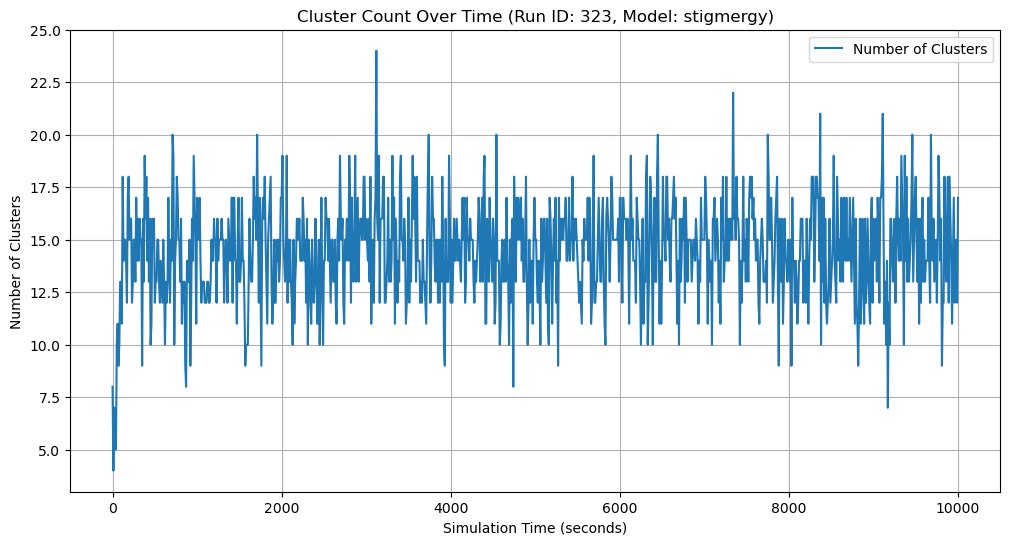

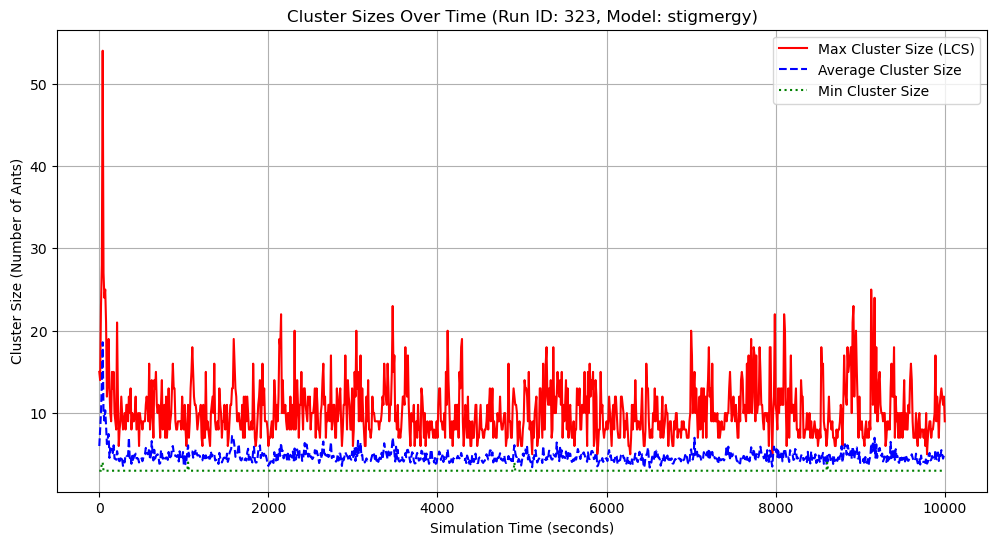

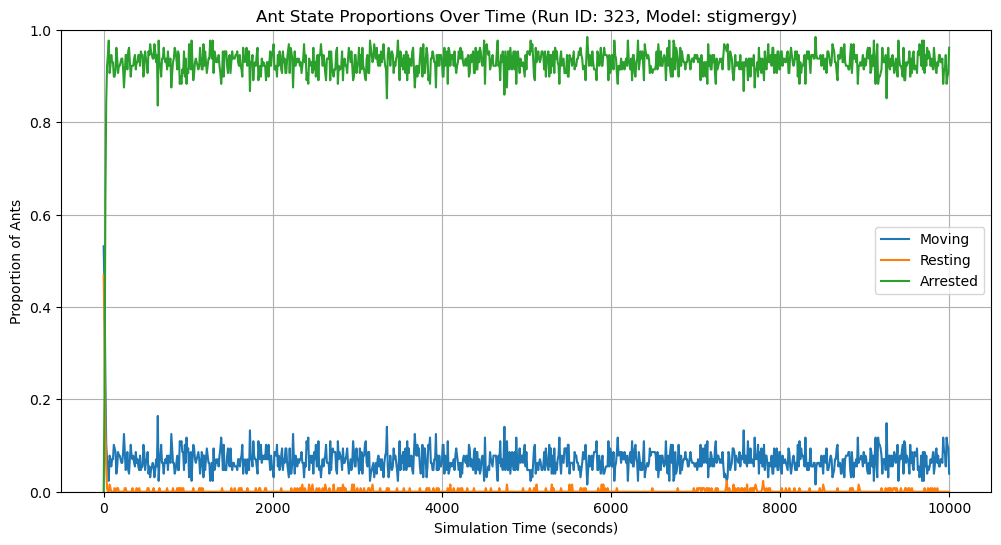

In [15]:
print("Runs with prominent cluster count peaks (example criteria):")
interesting_cluster_dynamics_df = summary_df[
    (summary_df['num_prominent_cluster_peaks'] > 0) & 
    (summary_df['highest_cluster_peak_prominence'] > 5) # Adjust threshold: 5 ants prominence
].sort_values(by='highest_cluster_peak_prominence', ascending=False)
print(interesting_cluster_dynamics_df.head())

# Pick a run_id from this table to plot
if not interesting_cluster_dynamics_df.empty:
    run_id_to_plot = interesting_cluster_dynamics_df.index[0]
    print(f"\nPlotting for run_id with interesting cluster dynamics: {run_id_to_plot}")
    processed_run_data_to_plot = load_processed_run_data(str(run_id_to_plot), PROCESSED_DATA_DIR) # Ensure run_id is string if needed
    if processed_run_data_to_plot:
        plot_cluster_counts(processed_run_data_to_plot)
        plot_cluster_sizes(processed_run_data_to_plot)
        plot_state_proportions(processed_run_data_to_plot)

Descriptive statistics for relevant columns:
       final_lcs_ratio_total_ants  max_lcs_growth_rate  \
count                  393.000000           393.000000   
mean                     0.080431            13.188295   
std                      0.161967            14.978051   
min                      0.000000             4.000000   
25%                      0.000000             5.000000   
50%                      0.000000             7.000000   
75%                      0.078125            14.000000   
max                      0.828125            78.000000   

       lcs_plateau_stability_last_quarter    num_ants  
count                          393.000000  393.000000  
mean                             3.466407  106.015267  
std                              4.585594   30.431083  
min                              0.927029   64.000000  
25%                              1.249955   64.000000  
50%                              1.531747  128.000000  
75%                              2.83644

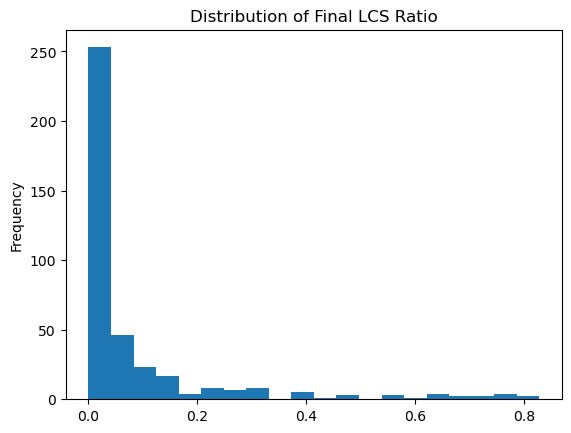

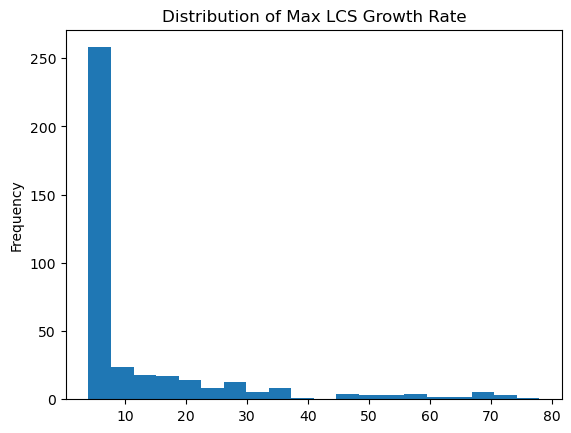

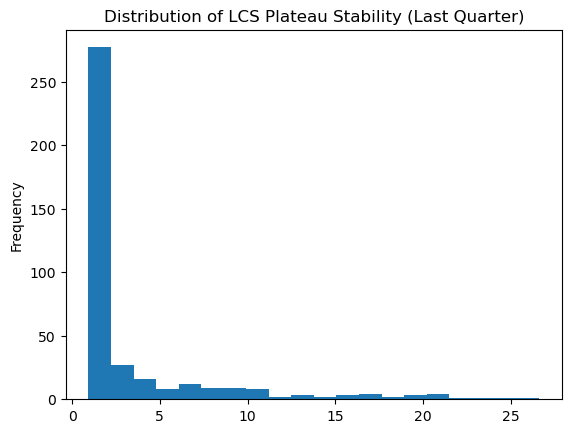

Runs with 'final_lcs_ratio_total_ants' > 0.7: 9 runs
Runs with 'max_lcs_growth_rate' > 5.30 (5% of mean num_ants): 242 runs
Runs with 'lcs_plateau_stability_last_quarter' < 2.12 (2% of mean num_ants): 275 runs


In [16]:
# Cell to inspect metric distributions for sigmoidal LCS growth
print("Descriptive statistics for relevant columns:")
print(summary_df[['final_lcs_ratio_total_ants', 'max_lcs_growth_rate', 'lcs_plateau_stability_last_quarter', 'num_ants']].describe())

print("\nConsider plotting histograms to see the distributions:")
summary_df['final_lcs_ratio_total_ants'].plot(kind='hist', bins=20, title='Distribution of Final LCS Ratio')
plt.show()
summary_df['max_lcs_growth_rate'].plot(kind='hist', bins=20, title='Distribution of Max LCS Growth Rate')
plt.show()
summary_df['lcs_plateau_stability_last_quarter'].plot(kind='hist', bins=20, title='Distribution of LCS Plateau Stability (Last Quarter)')
plt.show()

# Cell to test individual conditions

# Original Condition 1: Final LCS is a significant fraction of total ants
cond1_original_threshold = 0.7
num_satisfying_cond1 = summary_df[summary_df['final_lcs_ratio_total_ants'] > cond1_original_threshold].shape[0]
print(f"Runs with 'final_lcs_ratio_total_ants' > {cond1_original_threshold}: {num_satisfying_cond1} runs")

# Original Condition 2: Max growth rate is significant (using global mean num_ants)
mean_num_ants = summary_df['num_ants'].mean()
cond2_original_threshold_val = 0.05 * mean_num_ants
num_satisfying_cond2 = summary_df[summary_df['max_lcs_growth_rate'] > cond2_original_threshold_val].shape[0]
print(f"Runs with 'max_lcs_growth_rate' > {cond2_original_threshold_val:.2f} (5% of mean num_ants): {num_satisfying_cond2} runs")

# Original Condition 3: Plateau stability is low (using global mean num_ants)
cond3_original_threshold_val = 0.02 * mean_num_ants
num_satisfying_cond3 = summary_df[summary_df['lcs_plateau_stability_last_quarter'] < cond3_original_threshold_val].shape[0]
print(f"Runs with 'lcs_plateau_stability_last_quarter' < {cond3_original_threshold_val:.2f} (2% of mean num_ants): {num_satisfying_cond3} runs")


--- Runs with *REFINED* potential sigmoidal LCS growth criteria ---
Using thresholds: final_lcs_ratio > 0.6, growth_factor > 0.03, stability_factor < 0.05
Found 2 runs.
       model_type  num_ants  max_cluster_count  mean_cluster_count  \
run_id                                                               
352     stigmergy       128                  8            1.113886   
334     stigmergy       128                  8            1.117882   

        final_cluster_count  num_prominent_cluster_peaks  \
run_id                                                     
352                       1                          158   
334                       1                           45   

        highest_cluster_peak_val  highest_cluster_peak_time  \
run_id                                                        
352                            6                     3810.0   
334                            4                       30.0   

        highest_cluster_peak_prominence  cluster_rise_f

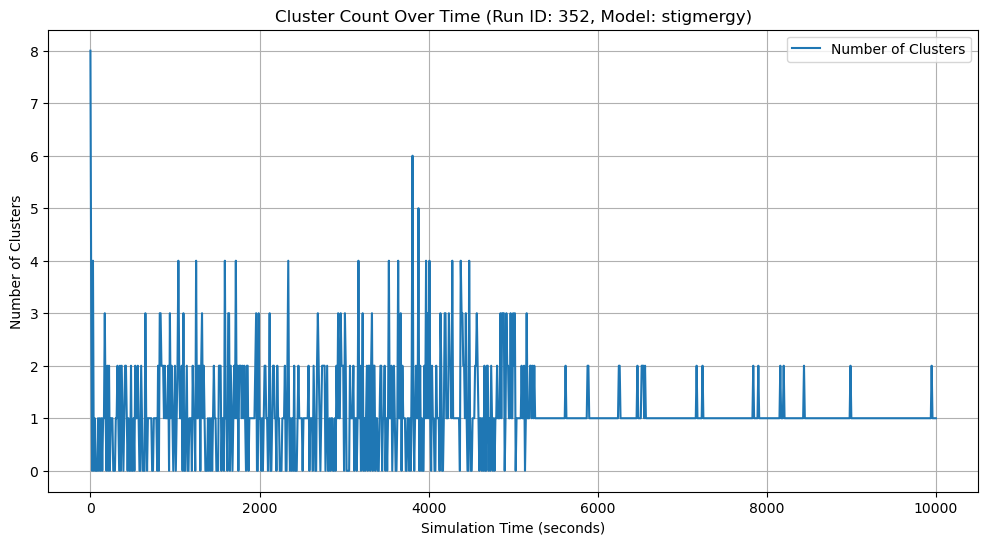

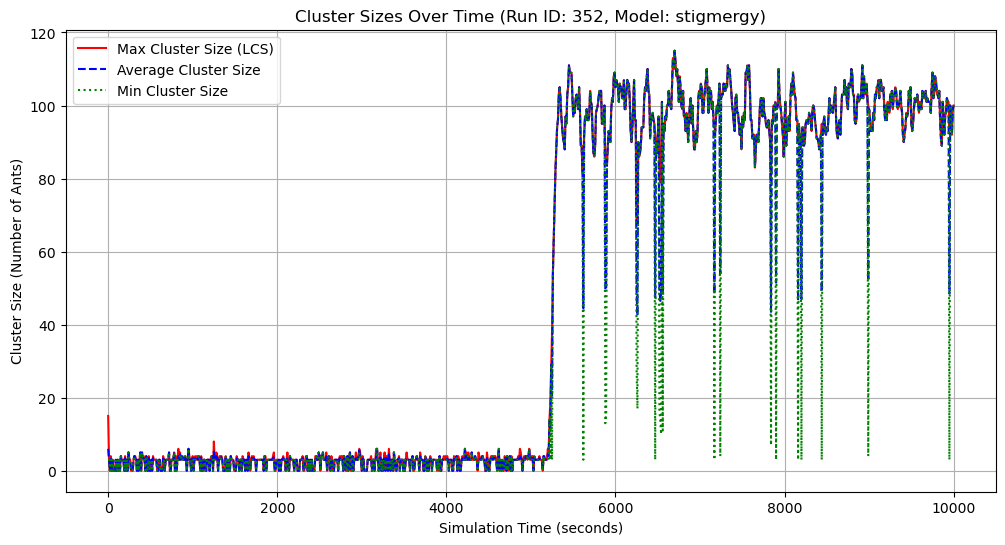

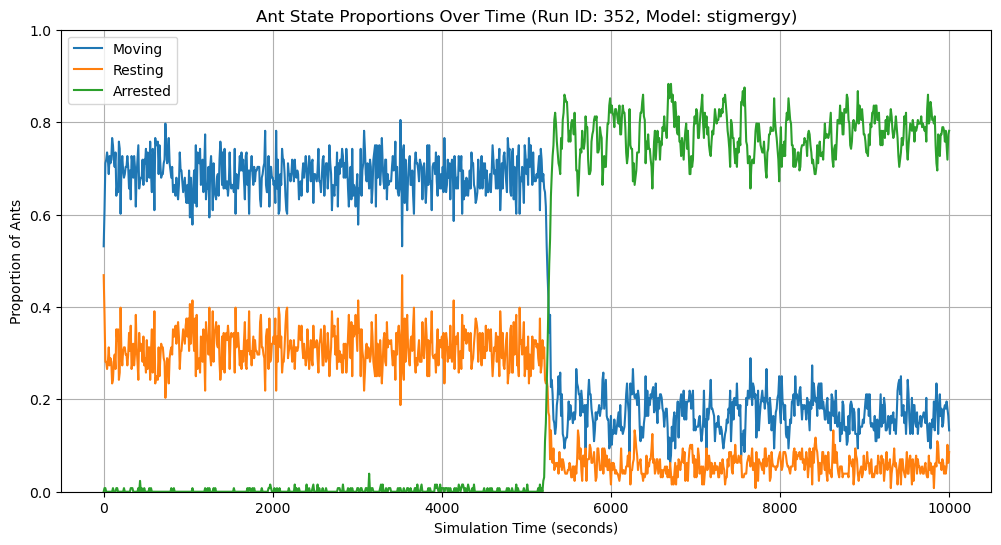

In [17]:
# Cell for refined sigmoidal LCS growth search

# --- Adjust these base thresholds after inspecting distributions ---
threshold_final_lcs_ratio = 0.6  # Example: Lowered from 0.7
threshold_growth_rate_factor = 0.03 # Example: Factor for growth rate relative to run's num_ants (3%)
threshold_stability_factor = 0.05   # Example: Factor for stability relative to run's num_ants (std dev < 5%)
# ---

# Condition 1: Final LCS is a significant fraction of the run's ants
cond1_refined = summary_df['final_lcs_ratio_total_ants'] > threshold_final_lcs_ratio

# Condition 2: Max growth rate is significant relative to the run's OWN num_ants
# This creates a per-run threshold
growth_rate_threshold_per_run = threshold_growth_rate_factor * summary_df['num_ants']
cond2_refined = summary_df['max_lcs_growth_rate'] > growth_rate_threshold_per_run

# Condition 3: Plateau stability is low relative to the run's OWN num_ants
# This creates a per-run threshold
stability_threshold_per_run = threshold_stability_factor * summary_df['num_ants']
cond3_refined = summary_df['lcs_plateau_stability_last_quarter'] < stability_threshold_per_run

# Combine the refined conditions
sigmoidal_lcs_df_refined = summary_df[cond1_refined & cond2_refined & cond3_refined].sort_values(by='max_lcs_growth_rate', ascending=False)

print(f"\n--- Runs with *REFINED* potential sigmoidal LCS growth criteria ---")
print(f"Using thresholds: final_lcs_ratio > {threshold_final_lcs_ratio}, growth_factor > {threshold_growth_rate_factor}, stability_factor < {threshold_stability_factor}")
if sigmoidal_lcs_df_refined.empty:
    print("Still no runs found with these refined criteria. Consider further loosening thresholds or checking metric calculations.")
else:
    print(f"Found {len(sigmoidal_lcs_df_refined)} runs.")
    print(sigmoidal_lcs_df_refined.head())

    # If runs are found, plot the top one as an example:
    if not sigmoidal_lcs_df_refined.empty:
        run_id_to_plot = sigmoidal_lcs_df_refined.index[0]
        print(f"\nPlotting for run_id with refined sigmoidal LCS dynamics: {run_id_to_plot}")
        # Ensure run_id_to_plot is the correct type (usually string for file names) for load_processed_run_data
        processed_run_data_to_plot = load_processed_run_data(str(run_id_to_plot), PROCESSED_DATA_DIR)
        if processed_run_data_to_plot:
            plot_cluster_counts(processed_run_data_to_plot)
            plot_cluster_sizes(processed_run_data_to_plot) # This is the key plot for LCS
            plot_state_proportions(processed_run_data_to_plot)
        else:
            print(f"Could not load processed data for run {run_id_to_plot}")